# Reconstructing Temporal connections of poisson data

In [2]:
import matplotlib.pyplot as plt
import torch

from data.reshape_data import reshape
from data.poisson_data_v import PoissonTimeShiftedData
from utils.funcs import shuffle_back
from boltzmann_machines.cp_rtrbm import RTRBM
from tqdm import tqdm

D:\Programs\anaconda\envs\rtrbm\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Programs\anaconda\envs\rtrbm\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


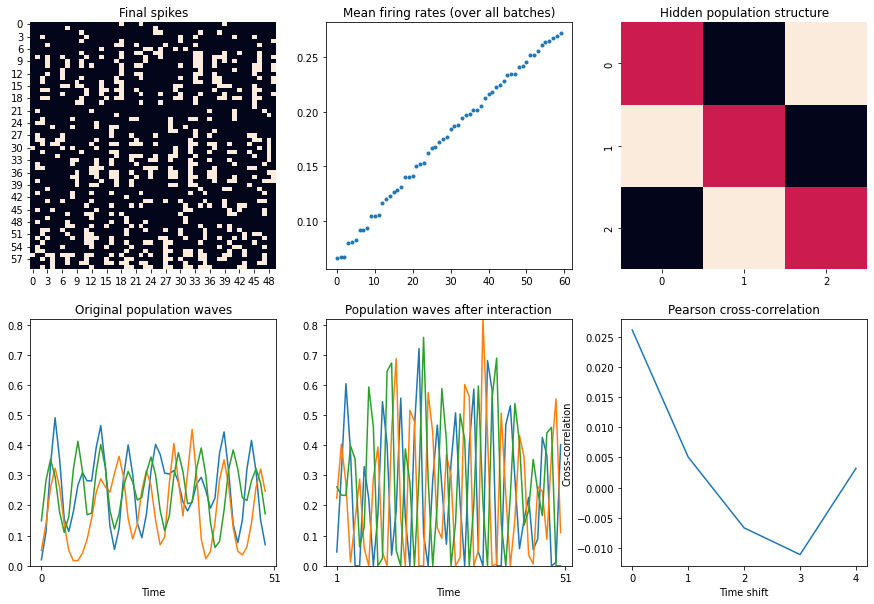

In [30]:
n_v = 60
n_h = 3
T = 50
n_batches = 500
delay = 1
temporal_connections = torch.tensor([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
]).float() * 2
frequency_range = [5, 10]
phase_range = [0, torch.pi]
amplitude_range = [0.4, 0.5]
gaus = PoissonTimeShiftedData(
    neurons_per_population=n_v//n_h, n_populations=n_h, n_batches=n_batches, time_steps_per_batch=T,
    fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
    frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range
)

axes = gaus.plot_stats()
plt.show()

100%|██████████| 200/200 [19:00<00:00,  5.70s/it]


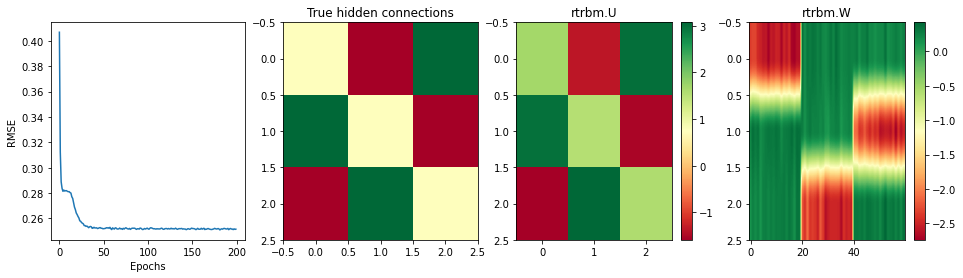

 48%|████▊     | 97/200 [10:12<10:50,  6.31s/it]


KeyboardInterrupt: 

In [32]:
n_v = 60
n_h = 3
T = 50
n_batches = 500
delay = 1
temporal_connections = torch.tensor([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
]).float() * 2
frequency_range = [5, 10]
phase_range = [0, torch.pi]
amplitude_range = [0.4, 0.5]

rtrbm_list, train_list, test_list = [], [], []
n_runs = 10
for i in range(n_runs):
    gaus = PoissonTimeShiftedData(
        neurons_per_population=n_v//n_h, n_populations=n_h, n_batches=n_batches, time_steps_per_batch=T,
        fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
        frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range
    )

    train, test = gaus.data[..., :400], gaus.data[..., 400:]

    rtrbm_gaus = RTRBM(train, N_H=n_h, device="cpu")
    rtrbm_gaus.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=0, x=1)

    rtrbm_list += [rtrbm_gaus]
    train_list += [train]
    test_list += [test]

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].plot(rtrbm_gaus.errors)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('RMSE')
    ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    ax[1].set_title('True hidden connections')
    cm = ax[2].imshow(rtrbm_gaus.U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    fig.colorbar(cm, ax=ax[2])
    ax[2].set_title('rtrbm.U')
    cm = ax[3].imshow(rtrbm_gaus.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    fig.colorbar(cm, ax=ax[3])
    ax[3].set_title('rtrbm.W')

    plt.show()

In [33]:
test = test_list[0]
train = train_list[0]
rtrbm = rtrbm_list[0]

## Sampling

In [213]:
# infer over all test batches
T, n_batches = test.shape[1], test.shape[2]
vs = torch.zeros(n_v, T, n_batches)
for batch in tqdm(range(n_batches)):
    vs[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


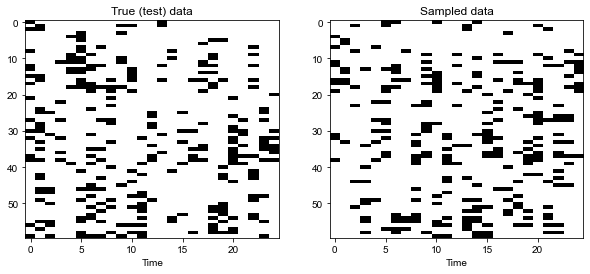

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(test[:, T//2:, 0], aspect='auto', cmap=plt.get_cmap('binary'))
axes[1].imshow(vs[:, T//2:, 0], aspect='auto', cmap=plt.get_cmap('binary'))

axes[0].set_title('True (test) data')
axes[0].set_xlabel('Time')
axes[1].set_title('Sampled data')
axes[1].set_xlabel('Time')

plt.show()

## Plot moments

In [24]:
plt.rcParams["font.family"] = "Arial"

In [70]:
from utils.funcs import pairwise_moments
from data.reshape_data import reshape_from_batches

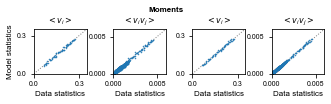

In [239]:
vs_ = reshape_from_batches(vs)
test_ = reshape_from_batches(test)
vvs = pairwise_moments(vs_, vs_)
vvt = pairwise_moments(test_, test_)

fig, axes = plt.subplots(1, 4, figsize=(4.46, 1.3))

ax = axes[2]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(torch.mean(test, (1, 2)), torch.mean(vs, (1, 2)), '.', markersize=1)
ax.set_xlim([0, .35])
ax.set_ylim([0, .35])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$<v_i>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)

ax = axes[3]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(vvt.flatten(), vvs.flatten(), '.', markersize=1)
ax.set_xlim([0, 6e-3])
ax.set_ylim([0, 6e-3])
ax.set_xticks([0, 5e-3])
ax.set_yticks([0, 5e-3])
ax.set_title('$<v_iv_j>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)

vs_rbm_ = reshape_from_batches(vs_rbm[:, :T//2, :])
vvs_rbm = pairwise_moments(vs_rbm_, vs_rbm_)

ax = axes[0]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(torch.mean(test, (1, 2)), torch.mean(vs_rbm, (1, 2)), '.', markersize=1)
ax.set_xlim([0, .35])
ax.set_ylim([0, .35])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$<v_i>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)
ax.set_ylabel('Model statistics', fontsize=8)

ax = axes[1]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(vvt.flatten(), vvs_rbm.flatten(), '.', markersize=1)
ax.set_xlim([0, 6e-3])
ax.set_ylim([0, 6e-3])
ax.set_xticks([0, 5e-3])
ax.set_yticks([0, 5e-3])
ax.set_title('$<v_iv_j>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)

fig.suptitle('Moments', fontsize=8, fontweight='bold')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('../../figures/Paper Figures/Figure 2/moments_RTRBM.png', dpi=1000)

plt.show()

In [194]:
from utils.funcs import get_reconstruction_mean_pairwise_correlations

In [195]:
results_rtrbm = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

## Train RBM for comparison

In [95]:
from boltzmann_machines.cp_rbm import RBM

rbm = RBM(train, N_H=n_h, device='cpu', debug_mode=False)
rbm.learn(n_epochs=200, batch_size=40, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002)

100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


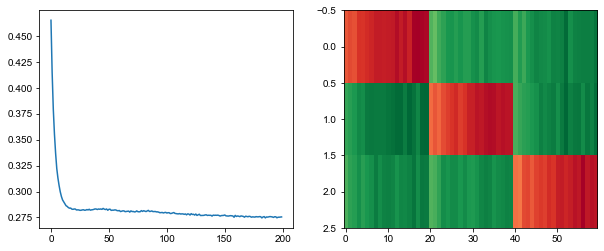

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(rbm.errors)
axes[1].imshow(rbm.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))

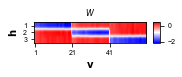

In [144]:
fig, ax = plt.subplots(figsize=(2.8, 1.17))
cm = ax.imshow(rbm.W, aspect='auto', cmap=plt.get_cmap('bwr'))
ax.set_title('$W$', fontsize=8)
ax.set_xticks([0, 20, 40])
ax.set_xticklabels([1, 21, 41], fontsize=7)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([1, 2, 3], fontsize=7)
ax.set_ylabel('$\mathbf{h}$')
ax.set_xlabel('$\mathbf{v}$')
cb = fig.colorbar(cm, ax=ax, aspect=3)
cb.ax.tick_params(labelsize=7)
plt.tight_layout()
plt.savefig('../../figures/Paper Figures/Figure 2/RBM_W.png', dpi=1000)
plt.show()


In [11]:
rtrbm = torch.load('rtrbm_list.pt')[19]
rbm = torch.load('rbm_list.pt')[8]

In [14]:
rbm_w = rbm.W[(1, 2, 0), :]
rtrbm_w = rtrbm.W[(2, 0, 1), :]

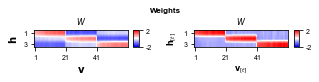

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(4.46, 1))

ax = axes[0]
cm = ax.imshow(rbm_w, aspect='auto', cmap=plt.get_cmap('bwr'), vmin=-2, vmax=2)
ax.set_title('$W$', fontsize=8)
ax.set_xticks([0, 20, 40])
ax.set_xticklabels([1, 21, 41], fontsize=7)
ax.set_yticks([0, 2])
ax.set_yticklabels([1, 3], fontsize=7)
ax.set_ylabel('$\mathbf{h}$')
ax.set_xlabel('$\mathbf{v}$')
cb = fig.colorbar(cm, ax=ax, aspect=3, ticks=[-2, 2])
cb.ax.tick_params(labelsize=7)
cb.ax.set_yticklabels([-2, 2])

ax = axes[1]
cm = ax.imshow(rtrbm_w[(0, 2, 1), :], aspect='auto', cmap=plt.get_cmap('bwr'), vmin=-2, vmax=2)
ax.set_title('$W$', fontsize=8)
ax.set_xticks([0, 20, 40])
ax.set_xticklabels([1, 21, 41], fontsize=7)
ax.set_yticks([0, 2])
ax.set_yticklabels([1, 3], fontsize=7)
ax.set_xlabel('$\mathbf{v}_{[t]}$', fontsize=8)
ax.set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8)
cb = fig.colorbar(cm, ax=ax, aspect=3, ticks=[-2, 2])
cb.ax.set_yticklabels([-2, 2])
cb.ax.tick_params(labelsize=7)
fig.suptitle('Weights', fontsize=8, fontweight='bold')

plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('../../figures/Paper Figures/Figure 2/RBM_RTRBM_W.png', dpi=1000)
plt.show()

In [22]:
temporal_connections = torch.tensor([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
]).float() * 2

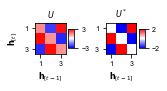

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(2.23, 1))
cm1 = axes[0].imshow(rtrbm.U, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-3, vmax=3)
cm2 = axes[1].imshow(temporal_connections, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-2, vmax=2)

cb1 = fig.colorbar(cm1, ax=axes[0], shrink=1, aspect=3, ticks=[-3, 3])
cb2 = fig.colorbar(cm2, ax=axes[1], shrink=1, aspect=3, ticks=[-2, 2])
cb1.ax.tick_params(labelsize=7)
cb2.ax.tick_params(labelsize=7)

ax=axes[0]
ax.set_xticks([0, 2])
ax.set_xticklabels([1, 3], fontsize=7)
ax.set_yticks([0, 2])
ax.set_yticklabels([1, 3], fontsize=7)
ax.set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8)
ax.set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8)

ax=axes[1]
ax.set_xticks([0, 2])
ax.set_xticklabels([1, 3], fontsize=7)
ax.set_yticks([0, 2])
ax.set_yticklabels([1, 3], fontsize=7)
ax.set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8)

axes[0].set_title('$U$', fontsize=8)
axes[1].set_title('$U^*$', fontsize=8)

plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('../../figures/Paper Figures/Figure 2/U_U_star.png', dpi=1000)

plt.show()

## Sampling RBM

In [196]:
T, n_batches = test.shape[1], test.shape[2]
vs = torch.zeros(n_v, T, n_batches)
for batch in tqdm(range(n_batches)):
    vs[:, :, batch], _ = rbm.sample(test[:, 0, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


In [ ]:
results_rbm = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

In [212]:
vs_rbm = vs

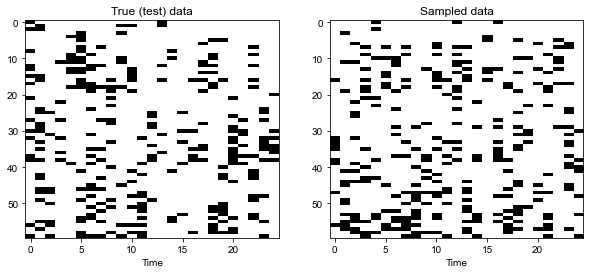

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(test[:, T//2:, 0], aspect='auto', cmap=plt.get_cmap('binary'))
axes[1].imshow(vs_rbm[:, T//2:, 0], aspect='auto', cmap=plt.get_cmap('binary'))

axes[0].set_title('True (test) data')
axes[0].set_xlabel('Time')
axes[1].set_title('Sampled data')
axes[1].set_xlabel('Time')

plt.show()

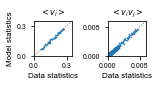

In [225]:
vs_ = reshape_from_batches(vs_rbm[:, :T//2, :])
test_ = reshape_from_batches(test[:, :T//2, :])
vvs = pairwise_moments(vs_, vs_)
vvt = pairwise_moments(test_, test_)
fig, axes = plt.subplots(1, 2, figsize=(2.23, 1.3))

ax = axes[0]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(torch.mean(test, (1, 2)), torch.mean(vs_rbm, (1, 2)), '.', markersize=1)
ax.set_xlim([0, .35])
ax.set_ylim([0, .35])
ax.set_xticks([0, .3])
ax.set_yticks([0, .3])
ax.set_title('$<v_i>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)
ax.set_ylabel('Model statistics', fontsize=8)

ax = axes[1]
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.plot(vvt.flatten(), vvs.flatten(), '.', markersize=1)
ax.set_xlim([0, 6e-3])
ax.set_ylim([0, 6e-3])
ax.set_xticks([0, 5e-3])
ax.set_yticks([0, 5e-3])
ax.set_title('$<v_iv_j>$', fontsize=8)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=8)

plt.tight_layout()
plt.savefig('../../figures/Paper Figures/Figure 2/moments_RBM.png', dpi=1000)

plt.show()

## Summary

In [223]:
T, n_batches = test.shape[1], test.shape[2]
vs_rbm = torch.zeros(n_v, T, n_batches)
for batch in tqdm(range(n_batches)):
    vs_rbm[:, :, batch], _ = rbm.sample(test[:, 0, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)


vs_rtrbm = torch.zeros(n_v, T, n_batches)
for batch in tqdm(range(n_batches)):
    vs_rtrbm[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

results_rbm = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])
results_rtrbm = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


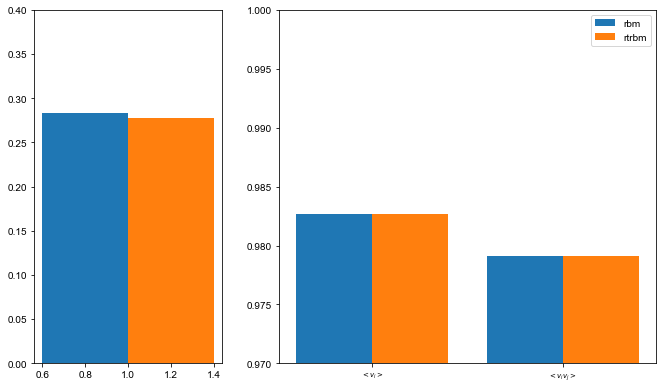

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(2.23*5, 1.3*5), gridspec_kw={'width_ratios': [1, 2]})

ax = axes[0]
ax.bar(.8, torch.mean((vs_rbm[:, :T//2, :] - test[:, :T//2, :])**2), width=.4)
ax.bar(1.2, torch.mean((vs[:, T//2:, :] - test[:, T//2:, :])**2), width=.4)
ax.set_ylim([0, .4])

ax = axes[1]
ax.bar(torch.arange(2) - .2, results_rbm[1:], label='rbm', width=.4)
ax.bar(torch.arange(2) + .2, results_rtrbm[1:], label='rtrbm', width=.4)
ax.set_ylim([.97, 1])
ax.legend()
ax.set_xticks([0, 1])
ax.set_xticklabels(['$<v_i>$', '$<v_iv_j>$'], fontsize=7)

plt.show()

## Average Connectivity